In [1]:
from osier import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import dill
import types
from functools import partial

In [2]:
path = "../data/2023-05-30-NOBJ4-USNGA3-results.pkl"
with open(path, 'rb') as file:
    results = dill.load(file)

In [3]:
results.exec_time/3600/24

26.450016904694063

In [97]:
techs = get_tech_names(results.problem.technology_list)

In [4]:
F = results.F
slack = 0.1
F_slack = F*(1+slack)

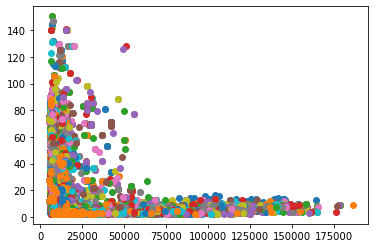

In [5]:
n_pts = 0
for i, h in enumerate(results.history):
    F_hist = h.pop.get("F")
    n_pts += len(F_hist)
    mask = F_hist < 1e40
    F_hist = np.ma.masked_values(F_hist, 1e40)
    plt.scatter(F_hist[:,0], F_hist[:,1])

In [6]:
def get_objective_names(res_obj):
    """
    This function returns a list of named objectives based on the
    names of the functions passed to Osier. In the case of partial
    functions, the first keyword value is used.
    
    Parameters
    ----------
    res_obj : :class:pymoo.Result
        The simulation results object containing all data and metadata.
    
    Returns
    -------
    obj_columns : list of str
        A list of function name strings.
    """
    obj_columns=[]
    for ofunc in res_obj.problem.objectives:
        if isinstance(ofunc, types.FunctionType):
            obj_columns.append(ofunc.__name__)
        elif isinstance(ofunc, functools.partial):
            obj_columns.append(list(ofunc.keywords.values())[0]) 
    return obj_columns

In [7]:
def moo_mga(res_obj, slack=0.1, sense='minimize'):
    """
    This function determines which individuals are 
    within the boundaries of a 'sub-optimal front'
    determined by a provided slack value.
    
    Parameters
    ----------
    res_obj : :class:pymoo.Result
        The simulation results object containing all data and metadata.
    slack : float
        The slack value for the sub-optimal front. 
    sense : str
        Indicates whether the optimization was a minimization 
        or maximization. If min, the sub-optimal front is greater
        than the Pareto front. If max, the sub-optimal front is 
        below the Pareto front.
    """
    pf = res_obj.F
    if sense.lower() == 'minimize':
        pf_slack = pf*(1+slack)
    elif sense.lower() == 'maximize':
        pf_slack = pf*(1-slack)
        
    n_objs = res_obj.problem.n_obj
    
    interior_dict = {n:[] for n in range(n_objs+1)}
    cols = get_objective_names(res_obj) + ['designs']
    
    # get list of all points
    for h in res_obj.history:
        # the history of each population, individual, 
        # and their corresponding design spaces.
        F_hist = h.pop.get("F")  # objective space
        X_hist = h.pop.get("X")  # design space
    
        for p, x in zip(F_hist, X_hist):
            # check that all coordinates of a point are within the boundaries.
            cond1 = np.any((p < pf_slack).sum(axis=1)==n_objs)
            cond2 = np.any((p > pf).sum(axis=1)==n_objs)
            if cond1 and cond2:
                for i,c in enumerate(p):
                    interior_dict[i].append(c)
                interior_dict[4].append(x)
    mga_df = pd.DataFrame(interior_dict)
    mga_df.columns = cols
    
    return mga_df

In [8]:
mdf = moo_mga(results)

In [9]:
obj_cols = get_objective_names(results)
obj_cols

['total_cost', 'lifecycle_co2_rate', 'land_use', 'percent_nonrenewable']

In [10]:
pf_obj = pd.DataFrame(dict(zip(obj_cols, F.T)))
pf_obj['optimal'] = 'Optimal'

In [11]:
pf_slack_obj = pd.DataFrame(dict(zip(obj_cols, F_slack.T)))
pf_slack_obj['optimal'] = 'Boundary'

In [12]:
mdf_obj = mdf.iloc[:,:4]
mdf_obj['optimal'] = 'Sub-opt'

In [22]:
mdf_obj_nondup = mdf_obj.drop_duplicates().reset_index(drop=True)
mdf_obj_nondup

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,optimal
0,6349.835709,21.668460,21507.513418,0.951782,Sub-opt
1,6344.245186,21.654545,21507.462122,0.952233,Sub-opt
2,5949.458670,20.005281,15416.608169,0.979554,Sub-opt
3,8309.882517,2.402467,6257.102949,0.992094,Sub-opt
4,8606.337239,2.550485,6271.208382,0.988252,Sub-opt
5,8341.828465,2.404744,6588.509200,0.988601,Sub-opt
6,5497.018807,27.930092,29295.654111,0.935974,Sub-opt
7,5520.749740,28.453851,29296.059147,0.935911,Sub-opt
8,6178.461961,13.610238,5504.969343,0.992079,Sub-opt
9,6273.116422,13.011507,5238.990823,0.974914,Sub-opt


In [92]:
results.X

array([[3.92264805e-02, 1.35019789e-03, 2.56714941e-02, 9.85391395e-04,
        8.82174717e-02, 2.16629672e-02, 3.79056946e-01, 4.94651454e-01,
        4.54929588e-02, 2.64785541e-04],
       [3.42433825e-01, 2.23978437e-02, 2.87292528e-02, 3.57287112e-03,
        2.55204195e-02, 7.33734844e-03, 4.73686321e-01, 1.14480866e-01,
        1.79215020e-02, 1.29915289e-04],
       [2.34814645e-01, 1.46304342e-04, 4.15991827e-02, 2.62712643e-03,
        1.67187763e-01, 9.17924037e-02, 4.35974956e-01, 5.34060066e-02,
        4.98170241e-01, 5.78118678e-03],
       [3.54287885e-01, 4.22893884e-05, 6.98213196e-02, 1.11415960e-03,
        7.74370698e-02, 9.26267713e-02, 3.12223243e-01, 5.41754505e-02,
        2.10179499e-01, 5.85849767e-03],
       [9.33634895e-05, 7.60085029e-01, 2.75052683e-02, 1.24492285e-03,
        3.90322672e-02, 1.52322920e-02, 8.73743794e-02, 6.13452805e-02,
        1.26605803e-02, 4.52367340e-03],
       [2.24329297e-02, 3.79146248e-03, 1.62414790e-02, 5.90813036e-05,
   

In [81]:
combined = pd.concat([pf_obj, mdf_obj_nondup], axis=0)

In [82]:
combined.reset_index(inplace=True, drop=True)

In [25]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .1), xycoords=ax.transAxes)

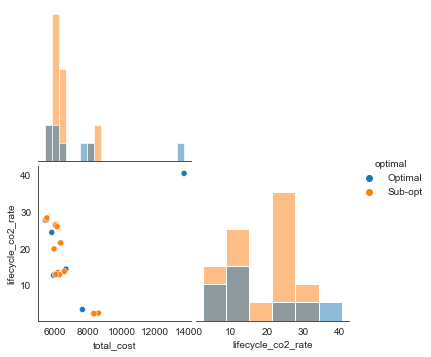

In [83]:
sb.set_style('white')
g = sb.pairplot(combined[['total_cost', 'lifecycle_co2_rate', 'optimal']], hue='optimal', diag_kind='hist', corner=True)
# g.map_lower(corrfunc)
plt.show()

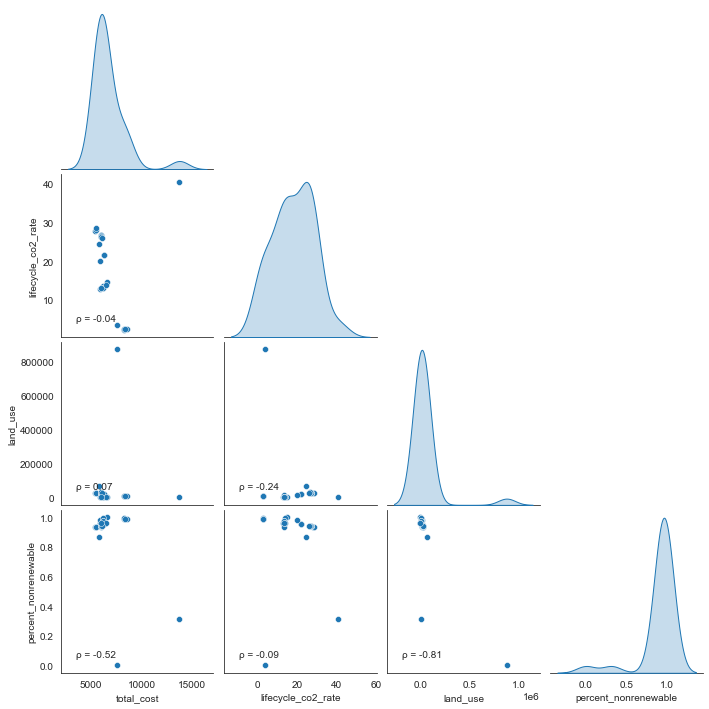

In [88]:
sb.set_style('white')
g = sb.pairplot(combined, diag_kind='kde', corner=True)
g.map_lower(corrfunc)
# g._legend.remove()
plt.show()

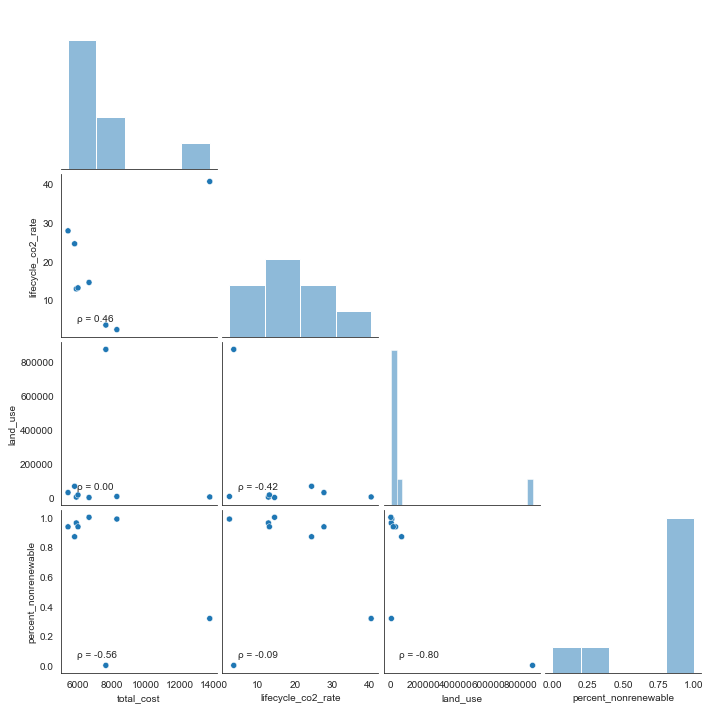

In [27]:
sb.set_style('white')
g = sb.pairplot(pf_obj, hue='optimal', diag_kind='hist', corner=True)
g.map_lower(corrfunc)
g._legend.remove()
plt.show()

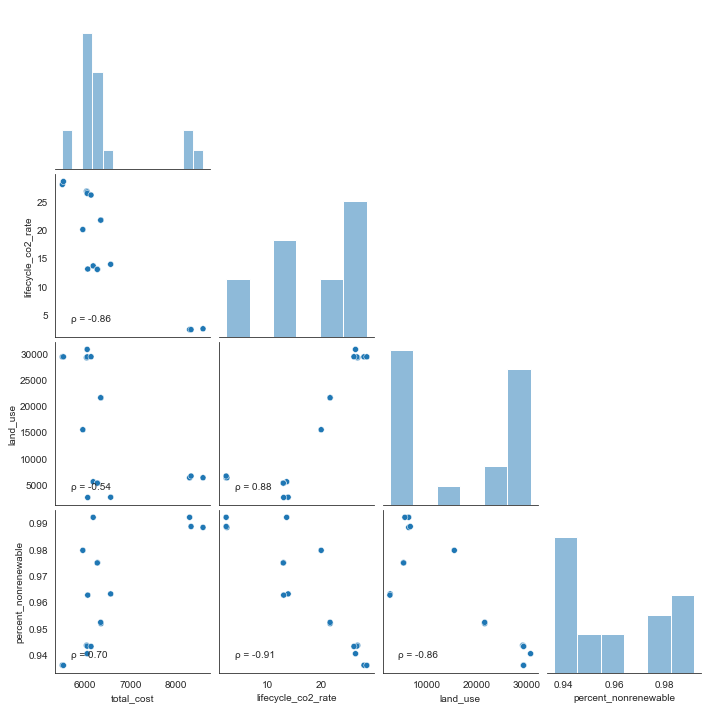

In [29]:
sb.set_style('white')
g = sb.pairplot(mdf_obj_nondup, hue='optimal', diag_kind='hist', corner=True)
g.map_lower(corrfunc)
g._legend.remove()
plt.show()

# Star Coordinate Plot

In [231]:
from pymoo.util.ref_dirs import get_reference_directions
ref_dirs = get_reference_directions("uniform", 4, n_partitions=5)

In [214]:
from pymoo.util.ref_dirs import get_reference_directions
ref_dirs2 = get_reference_directions("energy", 3, 250, seed=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


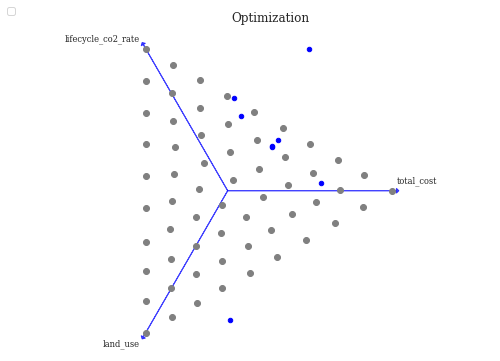

In [212]:
from pymoo.visualization.star_coordinate import StarCoordinate

plot = StarCoordinate(title="Optimization",
                      legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
                      labels=obj_cols[:3],
                      axis_style={"color": "blue", 'alpha': 0.7},
                      arrow_style={"head_length": 0.015, "head_width": 0.03})
plot.add(S[:,:3], color="blue", s=20)
plot.add(ref_dirs, color='grey')
# plot.add(F[65], color="red", s=70, label="Solution A")
# plot.add(F[72], color="green", s=70, label="Solution B")
plot.show()

# Radviz Plot

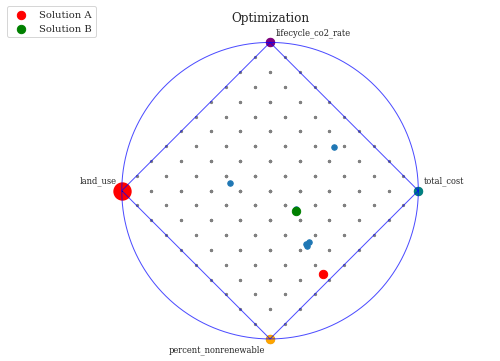

In [245]:
from pymoo.visualization.radviz import Radviz

N = 4
ref_dirs = get_reference_directions("uniform", N, n_partitions=10)
plot = Radviz(title="Optimization",
                      legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
                      labels=obj_cols[:N],
                      axis_style={"color": "blue", 'alpha': 0.7},
                      arrow_style={"head_length": 0.015, "head_width": 0.03},
                      )
plot.add(S[:,:N], color="tab:blue", s=30, facecolor='tab:blue', alpha=1)
plot.add(ref_dirs, color='grey',s=5)

plot.add(S[0], color="red", s=70, label="Solution A")
plot.add(S[2], color="green", s=70, label="Solution B")
# plot.add(np.array([0,0,0,1]), color='yellow', s=70)
plot.add(np.array([0,0,0,0.25]), color='orange', s=70)
plot.add(np.array([0,0,1,0]), color='k', s=70, edgecolor='red', lw=10)
plot.add(np.array([0,1,0,0]), color='purple', s=70)
plot.add(np.array([1,0,0,0]), color='teal', s=70)
plot.show()

In [236]:
display(S[0])
display(S[2])

array([0.60368703, 0.05798024, 0.00697178, 0.98819931])

array([0.42337631, 0.60392133, 0.07600783, 0.86892311])

In [200]:
S = F/F.max(axis=0)

# Ternary Plot

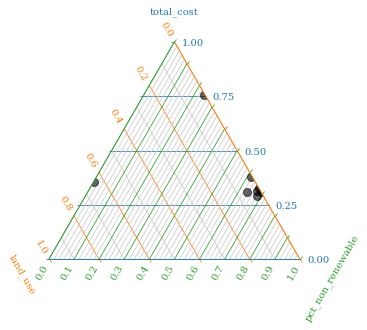

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

ax = plt.subplot(projection="ternary")



ax.scatter(S[:,0],S[:,2],S[:,3], s=64.0, c="k", edgecolors="k", alpha=0.6)

ax.set_tlabel("total_cost")
ax.set_llabel("land_use")
ax.set_rlabel("pct_non_renewable")

ax.taxis.set_major_locator(MultipleLocator(0.25))
ax.laxis.set_major_locator(MultipleLocator(0.20))
ax.raxis.set_major_locator(MultipleLocator(0.10))

ax.laxis.set_minor_locator(MultipleLocator(0.1))
ax.raxis.set_minor_locator(AutoMinorLocator(5))

ax.grid(axis='t', which='both')
ax.grid(axis='l', which='both', linestyle='-')
ax.grid(axis='r', which='both', linestyle='-')


# Color ticks, grids, tick-labels
ax.taxis.set_tick_params(tick2On=True, colors='C0', grid_color='C0')
ax.laxis.set_tick_params(tick2On=True, colors='C1', grid_color='C1')
ax.raxis.set_tick_params(tick2On=True, colors='C2', grid_color='C2')

# Color labels
ax.taxis.label.set_color('C0')
ax.laxis.label.set_color('C1')
ax.raxis.label.set_color('C2')

# Color spines
ax.spines['tside'].set_color('C0')
ax.spines['lside'].set_color('C1')
ax.spines['rside'].set_color('C2')
plt.show()

# 3D

In [43]:
pf_obj

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,optimal
0,8291.759444,2.351402,6084.317408,0.988145,Optimal
1,5916.763465,12.858772,2500.972545,0.961864,Optimal
2,5815.156413,24.492174,66332.563041,0.868875,Optimal
3,5430.836207,27.829462,29295.038375,0.935887,Optimal
4,13735.195512,40.555240,3418.998995,0.317540,Optimal
5,6661.768444,14.515464,143.977120,0.999945,Optimal
6,6014.911458,13.123974,15133.349082,0.936181,Optimal
7,7647.064947,3.516937,872706.989399,0.001334,Optimal


In [ ]:
pf_norm

In [46]:
pf3d = pf_obj.iloc[:,:3].values
pf3d_norm = pf3d / pf3d.max(axis=0)

In [39]:
obj_cols = list(pf_obj.iloc[:,:3].columns)

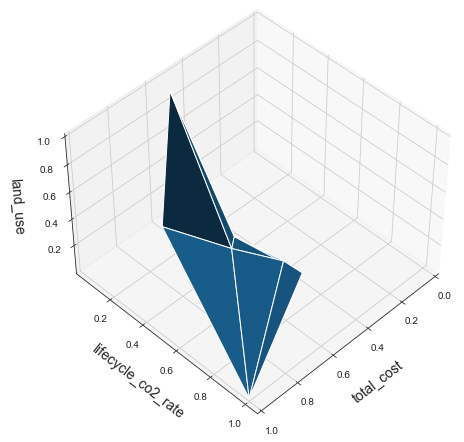

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use("pgf")
# plt.rcParams['pgf.texsystem'] = 'pdflatex'
# plt.rcParams['text.usetex'] = True
# plt.rcParams['pgf.rcfonts'] = False
# plt.rcParams['figure.edgecolor'] = 'k'
# plt.rcParams['figure.facecolor'] = 'w'
# plt.rcParams['savefig.dpi'] = 600
# plt.rcParams['savefig.bbox'] = 'tight'
# plt.rcParams['font.family'] = "serif"

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection="3d")

# create colormap according to x-value (can use any 50x50 array)
color_dimension = C # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
m.set_array([])
fcolors = m.to_rgba(color_dimension)



# ax.scatter3D(*zip(*pf))
ax.plot_trisurf(*zip(*pf3d_norm), alpha=1, )
# ax.scatter3D(*zip(*np.array(int_pts)), facecolor='tab:red')
# ax.scatter3D(*zip(*R), alpha=0.2, edgecolor='k', facecolor='None')
# ax.scatter3D(*zip(*pf_slack))
# ax.plot_trisurf(*zip(*pf_slack),color='tab:green', alpha=0.2)
ax.view_init(45, 45)
# ax.view_init(30, 60)
# ax.view_init(azim=225, elev=0, roll=0)
# ax.view_init(azim=225, elev=0, roll=0)




ax.set_xlim(0,1)
ax.set_xlabel(obj_cols[0], fontsize=14, labelpad=10)
ax.set_ylabel(obj_cols[1], fontsize=14, labelpad=10)
ax.set_zlabel(obj_cols[2], fontsize=14, labelpad=10)
# ax.set_box_aspect([1,1,1], zoom=0.78)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'land_use')

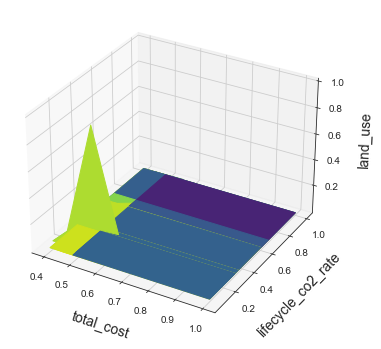

In [80]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# domains
x = pf3d_norm[:,0]
y = pf3d_norm[:,1]
z = pf3d_norm[:,2]
c = pf_obj['percent_nonrenewable'].values

# x = np.logspace(-1.,np.log10(5),50) # [0.1, 5]
# y = np.linspace(6,9,50)             # [6, 9]
# z = np.linspace(-1,1,50)            # [-1, 1]

# convert to 2d matrices
Z = np.outer(z.T, z)        # 50x50
C = np.outer(c.T, c)
X, Y = np.meshgrid(x, y)    # 50x50

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = C # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)
ax.set_xlabel(obj_cols[0], fontsize=14, labelpad=10)
ax.set_ylabel(obj_cols[1], fontsize=14, labelpad=10)
ax.set_zlabel(obj_cols[2], fontsize=14, labelpad=10)
# fig.canvas.show()

In [74]:
Z.shape

(8, 8)

In [75]:
C = 

array([0.98814495, 0.96186408, 0.86887532, 0.93588693, 0.31754041,
       0.99994499, 0.93618111, 0.00133443])

ValueError: Argument Z must be 2-dimensional.

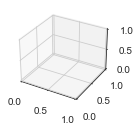

In [71]:
from matplotlib.colors import Normalize

# generate some data
# Z.ravel()[np.random.choice(Z.size, 10, replace=False)] = np.nan  # some values are nan
# C = np.cos(X) - np.sin(Y)  # 4th variable, to be represented in 4th dimension using colormap
# C[np.isnan(Z)] = np.nan  # corresponding values are nan

cmap = plt.cm.turbo
norm = Normalize(vmin=np.nanmin(C), vmax=np.nanmax(C))
fc = cmap(norm(C))

fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
# plot the surface for 4th dimension to get its colormap (facecolors)
surf = ax.plot_surface(X, Y, C, facecolors=fc)

ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=fc)

# Parallel Coordinates Plot

In [93]:
from pymoo.visualization.pcp import PCP

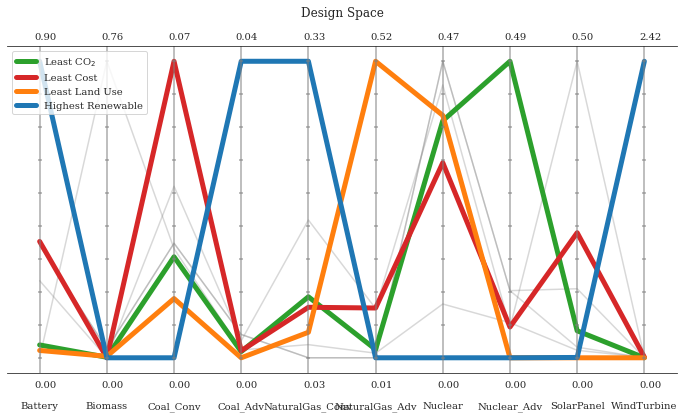

In [118]:
plot = PCP(title=("Design Space", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left"}),
           labels=techs,
           figsize=(12,6)
           )
plot.set_axis_style(color="grey", alpha=0.5)
plot.add(results.X, color="grey", alpha=0.3)



plot.add(results.X[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.X[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.X[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.X[7], linewidth=5, color="tab:blue", label="Highest Renewable")
plot.show()

In [122]:
ddf = pd.DataFrame(dict(zip(techs,results.X)))

In [113]:
pf_obj

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,optimal
0,8291.759444,2.351402,6084.317408,0.988145,Optimal
1,5916.763465,12.858772,2500.972545,0.961864,Optimal
2,5815.156413,24.492174,66332.563041,0.868875,Optimal
3,5430.836207,27.829462,29295.038375,0.935887,Optimal
4,13735.195512,40.555240,3418.998995,0.317540,Optimal
5,6661.768444,14.515464,143.977120,0.999945,Optimal
6,6014.911458,13.123974,15133.349082,0.936181,Optimal
7,7647.064947,3.516937,872706.989399,0.001334,Optimal


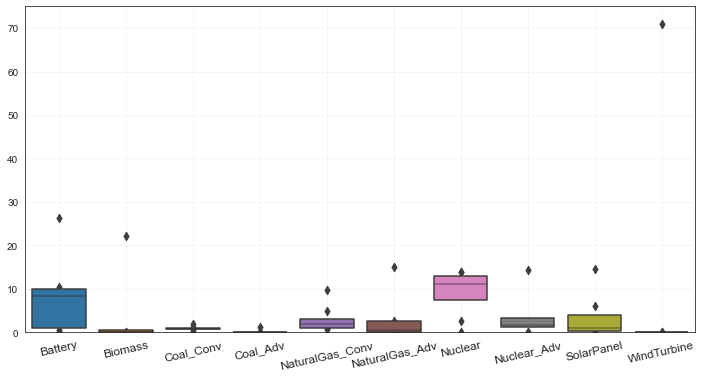

In [124]:
fig, axes = plt.subplots(1,1,figsize=(12,6), facecolor='w', sharex=True, sharey=True)
peak_demand = results.problem.max_demand
sb.boxenplot(ax=axes, data=(results.X)*peak_demand)

axes.set_xticklabels(techs, rotation=12.5, size=12)
axes.set_xticks(range(len(techs)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes.set_xlabel("", size=14)
axes.set_ylim(0,75)

axes.grid(alpha=0.2, which='major')
axes.grid(alpha=0.05, which='minor')